<a href="https://colab.research.google.com/github/siaSim/keras_deeplearning/blob/main/Binary_Classify_Drama_Revenant4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab에 Mecab 설치
!pip install konlpy
!pip install mecab-python
!pip install --upgrade matplotlib
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
total_data = pd.read_csv('./dramareview.csv', names=['reviews', 'ratings'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력


전체 리뷰 개수 : 117


In [ ]:
total_data[:5]

,reviews,ratings
박지현,"신기하게도, 모든 것이 부자연스럽다. 대궐같은 한옥에서의 첫장면만 한국식 호러물로써...",4.0
Magnolia,"악귀는 왜 악귀가 되었는가, 진정한 악은 무엇인가, 에 대한 소름 끼치는 진단서.\...",5.0
여수,김은희 작가는 왜 이렇게 고평가 되는 걸까 너무 유치하고 개연성 떨어지는 설정 동창...,2.0
윤제아빠,역시나..문제는 장르...\n.\n.\n#이장르는정말못보겠다\n#공감을못하는병인건가...,1.0
다현,내가 장담하는데 이거 방영하고 홍경 빵 뜬다에 내 손모가지 발모가지 다 건다.\n+...,5.0


In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,reviews,ratings,label
박지현,"신기하게도, 모든 것이 부자연스럽다. 대궐같은 한옥에서의 첫장면만 한국식 호러물로써...",4.0,1
Magnolia,"악귀는 왜 악귀가 되었는가, 진정한 악은 무엇인가, 에 대한 소름 끼치는 진단서.\...",5.0,1
여수,김은희 작가는 왜 이렇게 고평가 되는 걸까 너무 유치하고 개연성 떨어지는 설정 동창...,2.0,0
윤제아빠,역시나..문제는 장르...\n.\n.\n#이장르는정말못보겠다\n#공감을못하는병인건가...,1.0,0
다현,내가 장담하는데 이거 방영하고 홍경 빵 뜬다에 내 손모가지 발모가지 다 건다.\n+...,5.0,1


In [ ]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(5, 117, 2)

In [ ]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 117


In [ ]:
print(total_data.isnull().values.any())

True


In [ ]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 87
테스트용 리뷰의 개수 : 30


<Axes: >

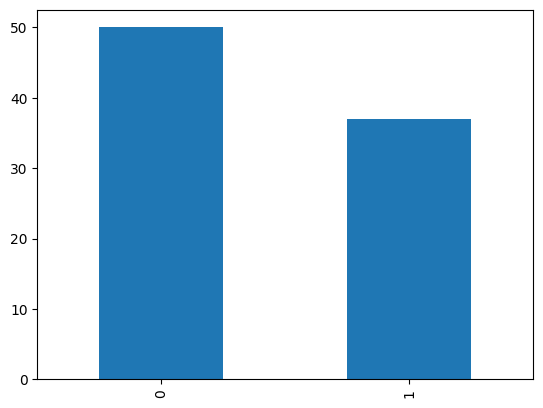

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))


   label  count
0      0     50
1      1     37


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())


reviews    0
ratings    0
label      0
dtype: int64


<ipython-input-55-5c91c21161d5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 29


<ipython-input-56-5968a3f5f2bc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


토큰화

In [ ]:
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']


In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [ ]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


단어와 길이 분포 확인하기

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)


In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))


[('너무', 19), ('보', 18), ('안', 15), ('거', 15), ('는데', 13), ('나', 12), ('좀', 12), ('까지', 11), ('아니', 11), ('되', 11), ('음', 11), ('김은희', 10), ('아', 10), ('대사', 10), ('왜', 10), ('면', 9), ('것', 9), ('화', 9), ('김', 9), ('없', 9)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))


[('귀신', 32), ('악귀', 20), ('면', 20), ('어', 18), ('만', 18), ('사람', 17), ('보', 17), ('안', 15), ('아', 15), ('나', 14), ('음', 14), ('같', 13), ('좋', 13), ('있', 13), ('더', 12), ('주', 12), ('아니', 12), ('돈', 11), ('것', 11), ('김', 11)]


긍정 리뷰의 평균 길이 : 48.45945945945946
부정 리뷰의 평균 길이 : 28.5


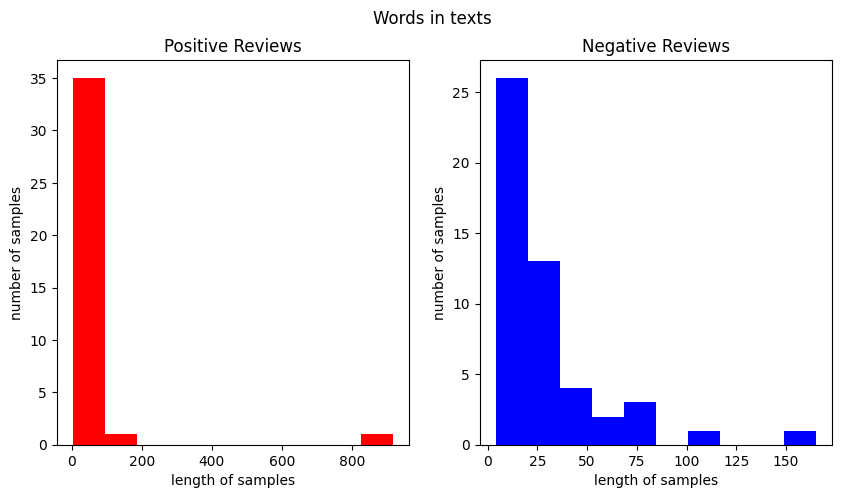

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

긍정리뷰가 부정리뷰보다 더 길게 작성됨을 알 수 있다.

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values


**정수인코딩**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 1330
등장 빈도가 1번 이하인 희귀 단어의 수: 839
단어 집합에서 희귀 단어의 비율: 63.0827067669173
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 26.072094468614043


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 493


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [ ]:
print(X_train[:3])


[[6, 7, 1, 6, 266, 267, 268, 169, 91, 139, 4, 24, 6, 47, 48, 9, 58, 10, 7, 40, 49, 20, 92, 1, 1, 49, 140, 1, 5, 93, 94, 11, 95, 73, 111, 7, 141, 1, 50, 34, 1, 51, 91, 1, 37, 74, 170, 142, 269, 141, 1, 270, 27, 27, 7, 1, 1, 50, 171, 8, 1, 1, 172, 2, 74, 143, 173, 34, 59, 1, 1, 1, 271, 1, 64, 1, 26, 15, 112, 8, 1, 1, 82, 272, 273, 1, 1, 41, 274, 8, 174, 1, 1, 275, 95, 1, 276, 49, 175, 5, 49, 1, 1, 277, 1, 1, 278, 1, 1, 1, 1, 174, 1, 1, 1, 279, 1, 111, 7, 1, 1, 1, 10, 280, 28, 277, 281, 282, 176, 6, 1, 2, 74, 1, 283, 65, 51, 141, 284, 1, 83, 1, 1, 1, 14, 1, 1, 1, 7, 1, 42, 1, 16, 7, 1, 1, 177, 176, 113, 93, 144, 84, 114, 12, 178, 1, 95, 276, 49, 267, 6, 21, 139, 115, 178, 1, 140, 1, 29, 139, 179, 285, 96, 145, 1, 58, 27, 286, 97, 1, 287, 115, 288, 1, 115, 25, 289, 290, 1, 41, 1, 12, 1, 1, 93, 11, 2, 40, 286, 20, 1, 291, 17, 11, 292, 1, 2, 3, 5, 288, 1, 1, 41, 1, 49, 1, 114, 4, 1, 180, 8, 293, 3, 146, 1, 15, 111, 294, 38, 52, 1, 49, 1, 271, 1, 1, 1, 40, 1, 95, 73, 49, 91, 60, 1, 1, 177, 49

In [ ]:
print(X_test[:3])


[[1, 30, 1, 1, 3, 64, 1, 294, 38, 1, 1, 10, 21, 1, 65, 251, 1, 1, 1, 20, 62, 1, 146, 30, 48, 10, 21, 245, 121, 1, 393, 26, 1, 1, 202, 137, 1, 146, 30, 1], [64, 1, 18, 1, 1, 1, 1, 1, 64, 1, 1, 1, 1, 1, 1, 13, 17, 245, 1, 1, 125], [1, 1, 55, 77, 1, 1, 1]]


패딩

리뷰의 최대 길이 : 918
리뷰의 평균 길이 : 36.98850574712644


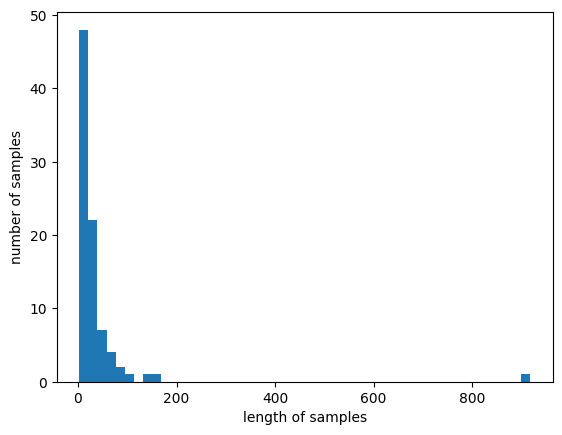

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 200
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 200 이하인 샘플의 비율: 98.85057471264368


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

GRU로 리뷰 감성 분류-임의문장리뷰예측

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 200
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='tanh'))  # 시그모이드 대신 tanh 활성화 함수 사용

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/15
2/2 [==============================] - ETA: 0s - loss: 2.6024 - acc: 0.5797
Epoch 1: val_acc improved from -inf to 0.55556, saving model to best_model.h5
2/2 [==============================] - 7s 2s/step - loss: 2.6024 - acc: 0.5797 - val_loss: 0.9268 - val_acc: 0.5556
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - ETA: 0s - loss: 0.7664 - acc: 0.5797
Epoch 2: val_acc did not improve from 0.55556
2/2 [==============================] - 1s 473ms/step - loss: 0.7664 - acc: 0.5797 - val_loss: 0.8130 - val_acc: 0.5556
Epoch 3/15
2/2 [==============================] - ETA: 0s - loss: 0.6739 - acc: 0.5797
Epoch 3: val_acc did not improve from 0.55556
2/2 [==============================] - 1s 487ms/step - loss: 0.6739 - acc: 0.5797 - val_loss: 0.7757 - val_acc: 0.5556
Epoch 4/15
2/2 [==============================] - ETA: 0s - loss: 0.6337 - acc: 0.5797
Epoch 4: val_acc did not improve from 0.55556
2/2 [==============================] - 2s 642ms/step - loss: 0.6337 - acc: 0.5797 - val_loss: 0.7357 - val_acc: 0.5556
Epoch 5/15
2/2 [==============================] - ETA: 0s - loss: 0.5906 - acc: 0.5797
Epoch 5: val_acc improved from 0.55556 to 0.61111, saving model to best_model.h5
2/2 [==============================] - 2s 735ms/step - loss: 0.5906 - acc: 0.5797 - val

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1/1 [==============================] - 1s 663ms/step - loss: 0.7802 - acc: 0.5172

 테스트 정확도: 0.5172


1/1 [==============================] - 0s 34ms/step


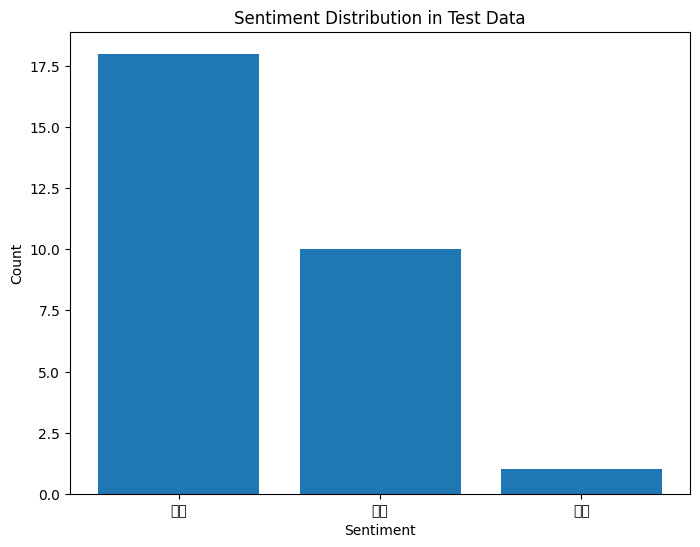

In [ ]:
# 예측 함수 수정
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', new_sentence)
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen=max_len)

    score = float(loaded_model.predict(pad_new))

    if score < 0.2:
        sentiment = 2  # 부정
    elif 0.2 <= score <= 0.4:
        sentiment = 1  # 중립
    else:
        sentiment = 0  # 긍정

    return sentiment

# 테스트 데이터 예측 및 결과 저장
test_data['predicted_sentiment'] = test_data['reviews'].apply(sentiment_predict)

# 결과를 그래프로 시각화
sentiments = [0, 1, 2]  # 0: 긍정, 1: 중립, 2: 부정
sentiment_labels = ['긍정', '중립', '부정']

# 각 클래스 레이블 별 개수 카운트
sentiment_counts = [len(test_data[test_data['predicted_sentiment'] == sentiment]) for sentiment in sentiments]

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(sentiments, sentiment_counts)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Test Data')

# 숫자를 감정 레이블로 변경하여 x 축에 표시
plt.xticks(sentiments, sentiment_labels)
plt.show()


In [ ]:
sentiment_predict('악귀 정말 재밌어요!!')

In [ ]:
sentiment_predict('악귀 너무 재미없어요 망한 작품이네요')

In [ ]:
sentiment_predict('너무 좋아요')

In [ ]:
sentiment_predict('평범하네요')